In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loại bỏ background

In [44]:
# Load dữ liệu text bounding box trong ảnh, được tạo ra trong create_word_metadata.py
with open('text_meta5.npy', 'rb') as f:
    bboxes = np.load(f)

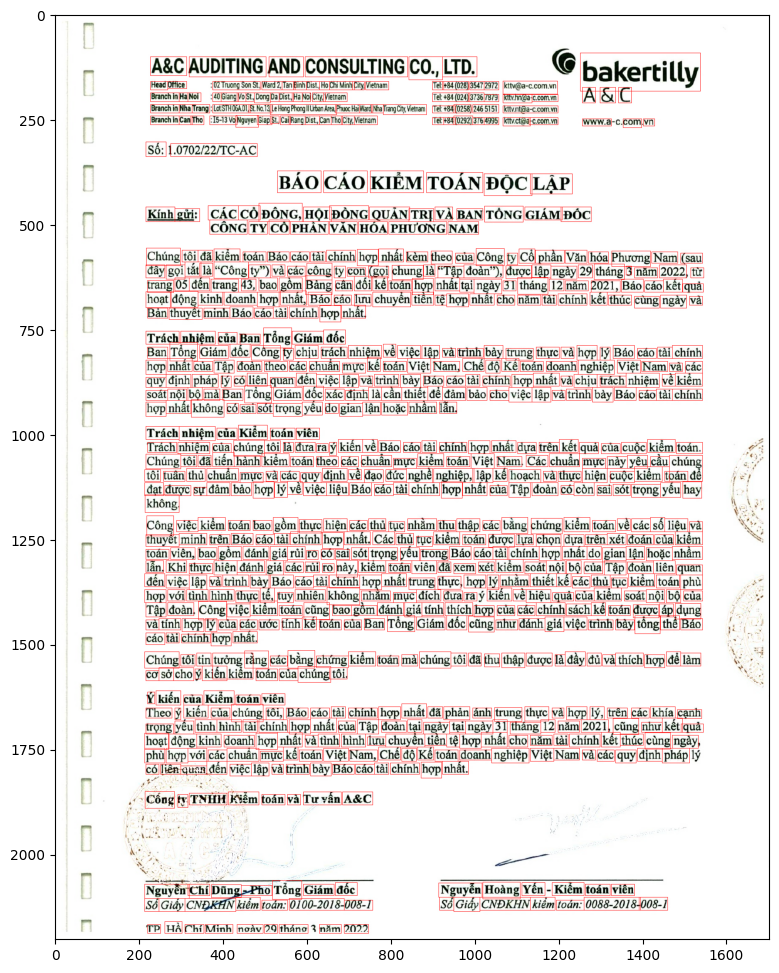

In [45]:
# plot bounding box của text trong ảnh, có nguồn từ signature-detection-and-remove/result/preprocess
image = cv2.imread('test5removestamp-result.jpg')
for box in bboxes:
  color = 255
  image = cv2.rectangle(image, box[0].astype('int32'), box[2].astype('int32'), color, 1)
plt.figure(figsize=(20,12))
plt.imshow(image)

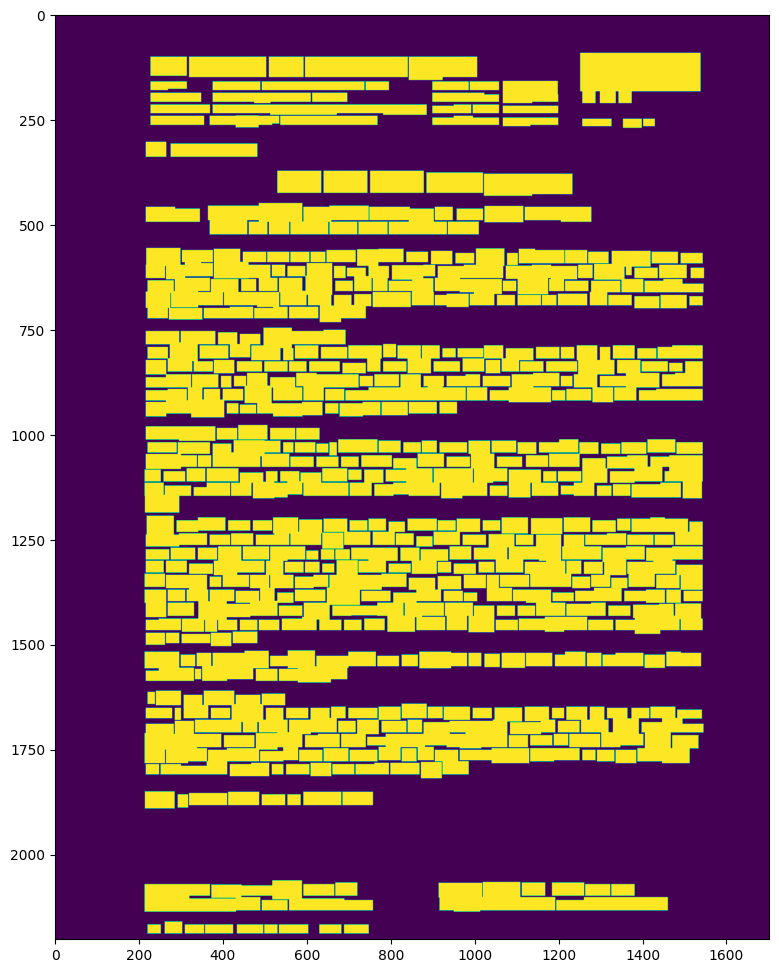

In [46]:
# Tạo mask cho ảnh ứng với các bounding box
mask = np.zeros((image.shape[0], image.shape[1]))
for box in bboxes:
  color = 255
  mask = cv2.rectangle(mask, box[0].astype('int32'), box[2].astype('int32'), color, -1)
plt.figure(figsize=(20,12))
plt.imshow(mask)

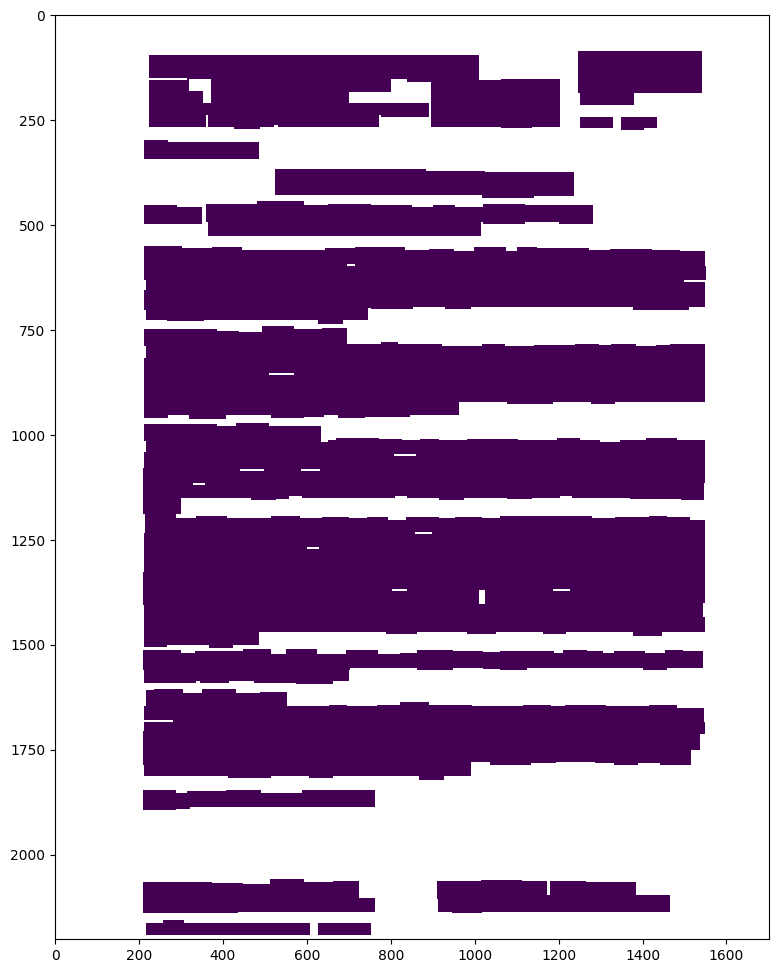

In [47]:
# Dilate mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
dilate = cv2.dilate(mask, kernel, iterations=1)
plt.figure(figsize=(20,12))
plt.imshow(cv2.bitwise_not(dilate))

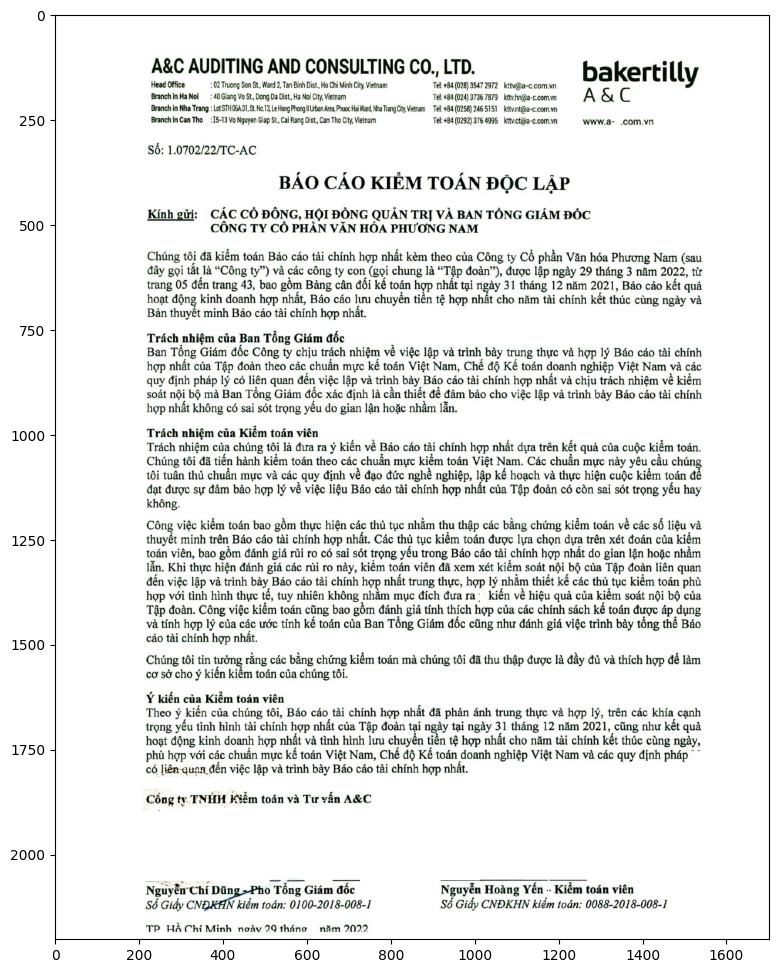

In [48]:
# Loại bỏ background của ảnh
image = cv2.imread('test5removestamp-result.jpg')
mask = cv2.bitwise_not(dilate.astype('uint8'))
image = (image*(np.expand_dims(cv2.bitwise_not(mask)/255, axis=2))+np.expand_dims(mask, axis=2)).astype('uint8')
plt.figure(figsize=(20,12))
plt.imshow(image)

# Tìm các text region trong ảnh

https://stackoverflow.com/questions/57249273/how-to-detect-paragraphs-in-a-text-document-image-for-a-non-consistent-text-stru

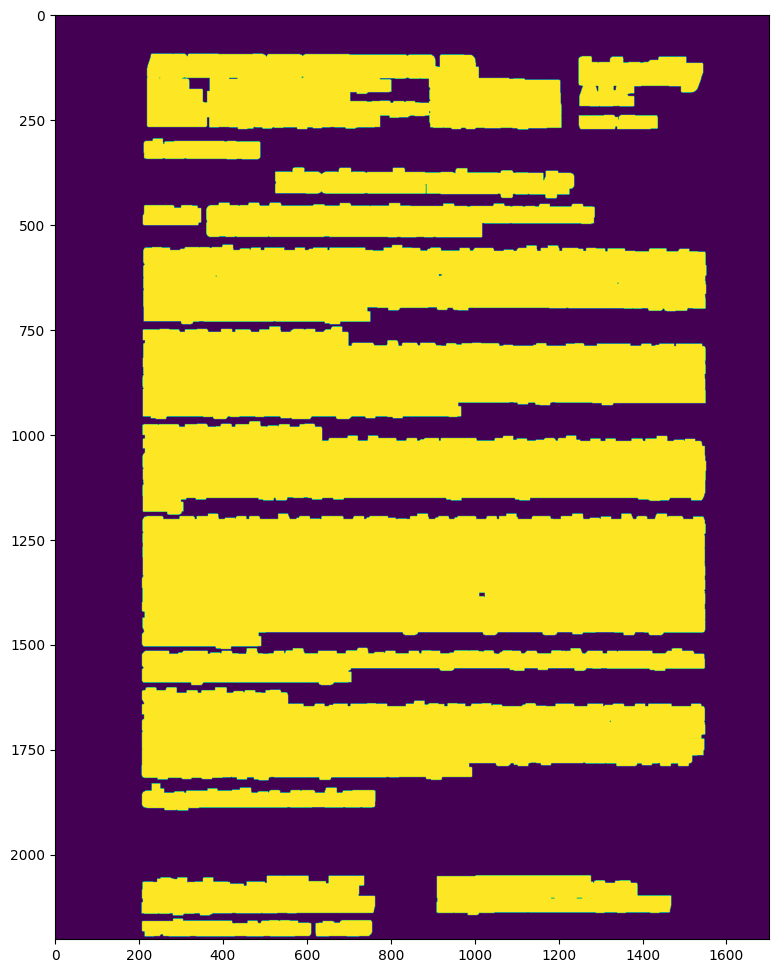

In [49]:
import cv2
import numpy as np
# Tạo dilate cho ảnh preprocess
# Load image, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('/content/test5-preprocess.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=5)
plt.figure(figsize=(20,12))
plt.imshow(dilate)

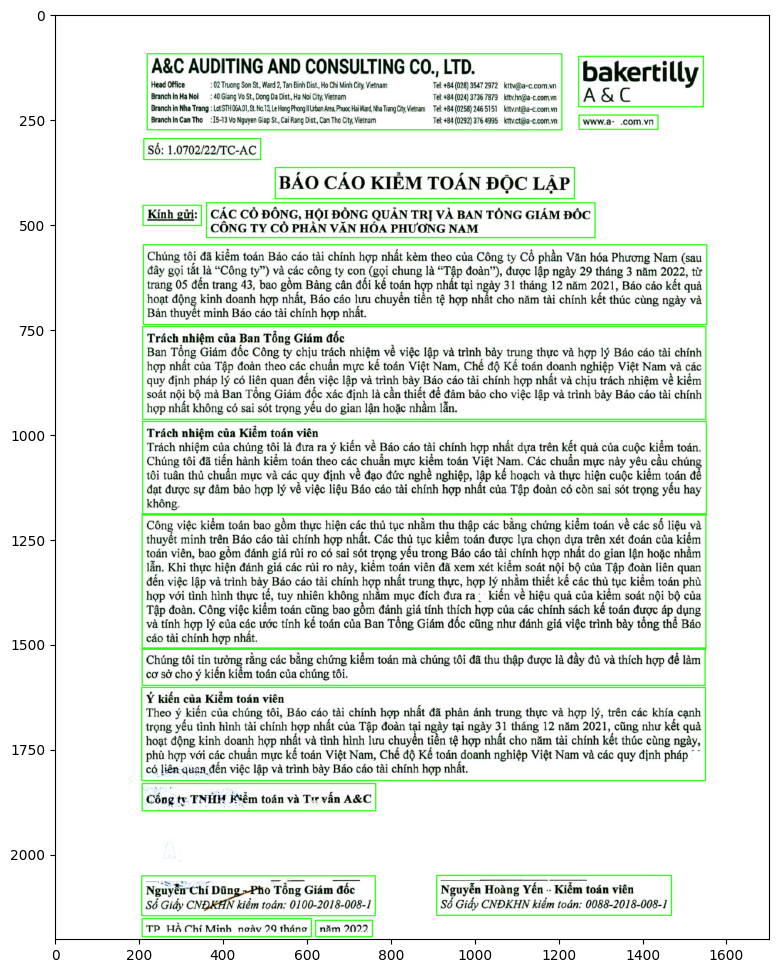

In [50]:
# Tìm các contour và vẽ bounding box cho các contour đó
# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
count=0
for idx, c in enumerate(cnts):
    count+=1
    x,y,w,h = cv2.boundingRect(c)
    # Lưu các contour tìm được để phục vụ cho phần line detection
    cv2.imwrite('{}.jpg'.format(idx), image[y:y+h, x:x+w])
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
plt.figure(figsize=(20,12))
plt.imshow(image)

# Test line prediction

In [51]:
# Load ảnh đầu vào, xoay ảnh và chuyển ảnh sang ảnh xám
img1 = cv2.imread('8.jpg')
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img3 = np.transpose(img2)
img = np.arange(16).reshape((4,4))

In [52]:
# Tạo kernel cho filter ảnh
import math
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

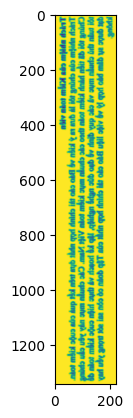

In [53]:
kernelSize=9
sigma=4
theta=1.5
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
plt.imshow(imgFiltered1)

In [54]:
# Normalize ảnh filter và tính tổng theo trục y
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

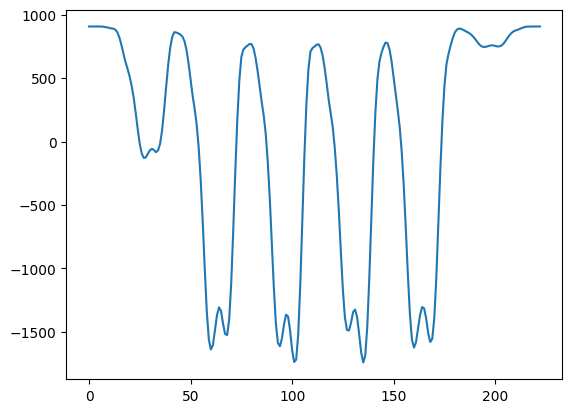

In [55]:
(m, s) = cv2.meanStdDev(imgFiltered1)
summ = applySummFunctin(img4)
plt.plot(summ)
plt.show()

In [56]:
# Làm mịn histogram của ảnh
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

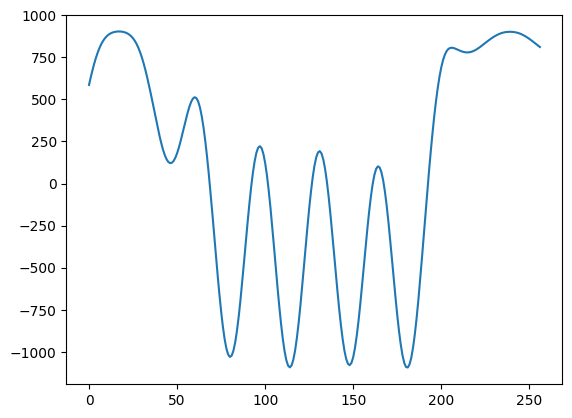

In [57]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
plt.plot(smoothed)
plt.show()

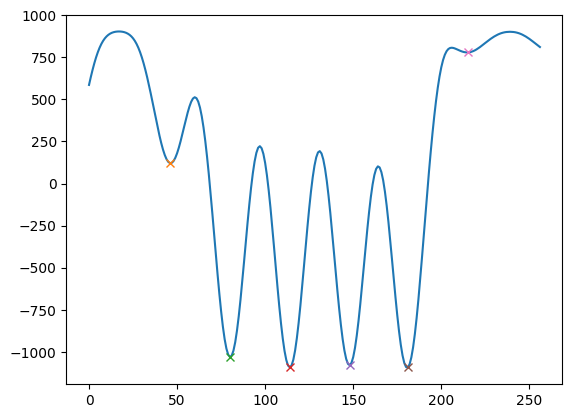

In [58]:
# Tìm ra các điểm cực tiểu địa phương
from scipy.signal import argrelmin
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)
plt.plot(smoothed)
plt.plot(arr_mins, smoothed[arr_mins], "x")
plt.show()

In [59]:
# Crop ảnh và visualize các dòng
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines

In [60]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [61]:
found_lines = crop_text_to_lines(img3, arr_mins[0])

x1= 0 , x2= 46 , Diff=  46
x1= 46 , x2= 80 , Diff=  34
x1= 80 , x2= 114 , Diff=  34
x1= 114 , x2= 148 , Diff=  34
x1= 148 , x2= 181 , Diff=  33
x1= 181 , x2= 215 , Diff=  34


In [62]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

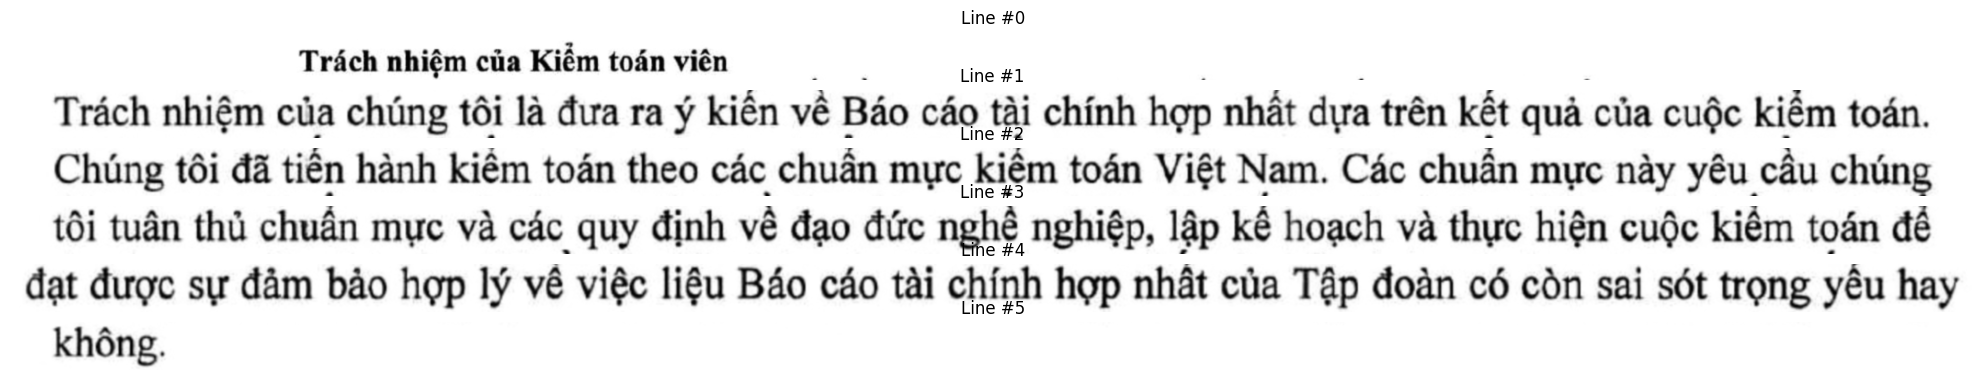

In [63]:
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')